<a href="https://colab.research.google.com/github/ccubc/DS_self_learning/blob/master/deep_learning/time_series_4_sun_spot_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

TensorFlow 2.x selected.
2.1.0-rc1


In [0]:
import numpy as np
import matplotlib.pyplot as plt
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

In [3]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv \
    -O /tmp/sunspots.csv

--2020-01-09 06:31:13--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/Sunspots.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.125.128, 2404:6800:4008:c05::80
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.125.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 70827 (69K) [application/octet-stream]
Saving to: ‘/tmp/sunspots.csv’

/tmp/sunspots.csv   100%[===================>]  69.17K  --.-KB/s    in 0.001s  

2020-01-09 06:31:18 (116 MB/s) - ‘/tmp/sunspots.csv’ saved [70827/70827]



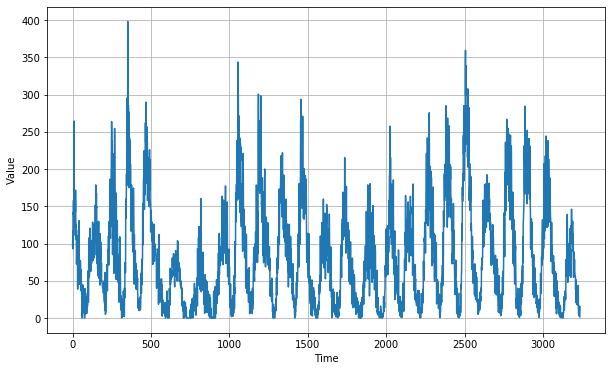

In [4]:
import csv
time_step = []
sunspots = []

with open('/tmp/sunspots.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  for row in reader:
    sunspots.append(float(row[2]))
    time_step.append(int(row[0]))

series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

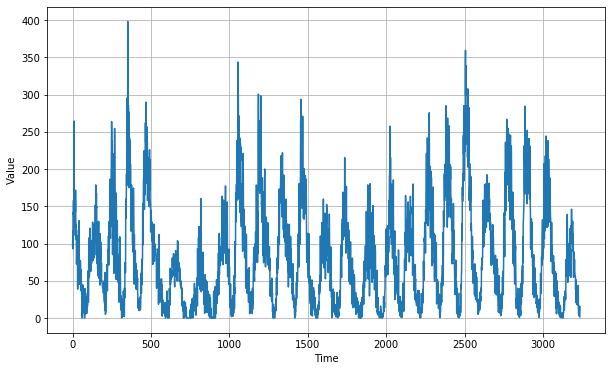

In [5]:
series = np.array(sunspots)
time = np.array(time_step)
plt.figure(figsize=(10, 6))
plot_series(time, series)

In [0]:
split_time = 3000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 30
batch_size = 32
shuffle_buffer_size = 1000



In [0]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [0]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [9]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
window_size = 64
batch_size = 256
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print(x_train.shape)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])




<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
(3000,)
Epoch 1/100
12/12 [==============================] - 9s 744ms/step - loss: 80.2708 - mae: 80.3315
Epoch 2/100
12/12 [==============================] - 1s 76ms/step - loss: 78.2509 - mae: 78.5896
Epoch 3/100
12/12 [==============================] - 1s 78ms/step - loss: 75.6613 - mae: 75.9445
Epoch 4/100
12/12 [==============================] - 1s 78ms/step - loss: 72.3021 - mae: 72.7693
Epoch 5/100
12/12 [==============================] - 1s 79ms/step - loss: 69.0174 - mae: 69.2661
Epoch 6/100
12/12 [==============================] - 1s 81ms/step - loss: 65.3797 - mae: 65.6140
Epoch 7/100
12/12 [==============================] - 1s 82ms/step - loss: 61.9061 - mae: 62.0189
Epoch 8/100
12/12 [==============================] - 1s 76ms/step - loss: 58.0653 - mae: 58.6465
Epoch 9/100
12/12 [==============================] - 1s 82ms/step - loss: 55.4543 - mae: 55.5682
Epoch 10/100
12/12 [====

[1e-08, 0.0001, 0, 60]

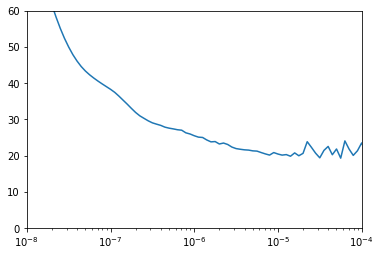

In [10]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 60])

In [11]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=60, batch_size=100, shuffle_buffer=shuffle_buffer_size)
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=60, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set,epochs=500)

Epoch 1/500
30/30 [==============================] - 4s 125ms/step - loss: 37.8972 - mae: 38.6064
Epoch 2/500
30/30 [==============================] - 1s 42ms/step - loss: 24.0763 - mae: 24.6128
Epoch 3/500
30/30 [==============================] - 1s 41ms/step - loss: 22.0275 - mae: 22.5238
Epoch 4/500
30/30 [==============================] - 1s 42ms/step - loss: 19.8236 - mae: 20.3079
Epoch 5/500
30/30 [==============================] - 1s 41ms/step - loss: 19.4789 - mae: 19.9635
Epoch 6/500
30/30 [==============================] - 1s 41ms/step - loss: 19.1954 - mae: 19.6914
Epoch 7/500
30/30 [==============================] - 1s 42ms/step - loss: 18.6266 - mae: 19.1038
Epoch 8/500
30/30 [==============================] - 1s 42ms/step - loss: 18.3452 - mae: 18.8543
Epoch 9/500
30/30 [==============================] - 1s 42ms/step - loss: 18.4253 - mae: 18.9025
Epoch 10/500
30/30 [==============================] - 1s 42ms/step - loss: 18.5839 - mae: 19.0329
Epoch 11/500
30/30 [========

In [0]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

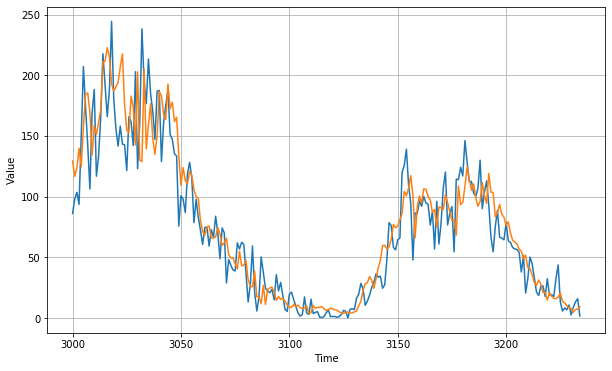

In [13]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [14]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

16.457453

<Figure size 432x288 with 0 Axes>

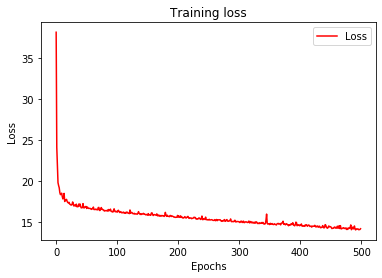

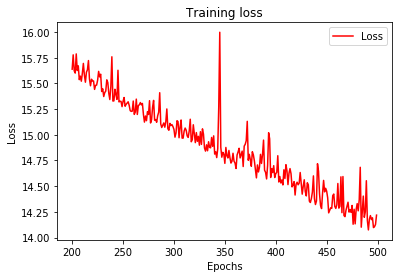

<Figure size 432x288 with 0 Axes>

In [15]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()



zoomed_loss = loss[200:]
zoomed_epochs = range(200,500)


#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(zoomed_epochs, zoomed_loss, 'r')
plt.title('Training loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss"])

plt.figure()

In [16]:
print(rnn_forecast)

[129.3265    116.58397   123.959015  139.83893   124.51715   157.52322
 184.51106   185.34767   169.44653   134.14342   158.69601   151.0284
 161.2106    171.42642   211.25107   211.48143   222.74043   215.42444
 192.92386   186.90059   190.58516   193.99356   206.60588   217.65227
 175.6009    154.84016   152.71266   182.81906   173.35062   142.52234
 202.77946   130.14183   128.72353   205.16965   139.33795   159.00655
 176.53436   147.59991   134.92308   150.33183   186.67323   182.7963
 167.81561   163.51637   192.74907   172.36984   177.81245   161.89702
 165.39116   133.5959    109.31995   123.851204  113.09971   110.50373
 120.81226   117.759636  105.582794  100.15876    98.43319    80.150795
  71.20998    68.24902    74.95897    75.748146   66.03692    65.83575
  66.84566    74.3062     69.31393    59.8458     61.855263   65.76966
  52.2954     49.293655   49.606342   44.56746    40.49474    54.96917
  42.89715    43.528698   47.378445   31.446617   26.170387   25.670347
  38.4